# Common Imports

In [1]:
from torch import Tensor, no_grad, nn, optim, cat

import numpy as np
import matplotlib.pyplot as plt

# Diff Equation

## Fisher-Kolmogorov Equation

In [2]:
from phylearn.domain import DiffEquation


In [3]:
class FisherKolmogorovDiffEquation(DiffEquation[Tensor, Tensor]):
    def __init__(self, boundary_condition: Tensor, limit: float) -> None:
        self._boundary_condition = boundary_condition
        self._limit = limit

    def __call__(self, observation: Tensor, params: Tensor) -> Tensor:
        D, p = params[:, 0], params[:, 1]

        params_shape = (len(observation), *[1 for _ in observation.shape[1:]])
        D = D.reshape(params_shape)
        p = p.reshape(params_shape)
        
        with no_grad():
            du_dxs = sum(
                [
                    np.gradient(np.gradient(observation, axis=x), axis=x)
                    for x in range(2, len(observation.shape))
                ]
            )
        du_dxs = Tensor(du_dxs)

        # Fisher-Kolmogorov
        diff = D * du_dxs + p * observation * (1 - observation)

        # Clip values
        diff = diff.clip(0, self._limit)

        # boundary condition
        diff[:, :] *= self._boundary_condition

        return diff

## Boundary Condition

In [4]:
from torch import ones, rand
from itertools import product

In [5]:
state_shape = (1, 32, 32)

boundary_condition = ones(state_shape[1:])

center_x = boundary_condition.shape[0] // 2
center_y = boundary_condition.shape[1] // 2

radius = center_x

for x, y in product(range(boundary_condition.shape[0]), range(boundary_condition.shape[1])):
    distance = ((x - center_x) ** 2 + (y - center_y) ** 2) ** 0.5
    if distance >= radius:
        boundary_condition[x, y] = 0.0
    elif distance <= radius / 2:
        boundary_condition[x, y] *= 0.8

messed_boundary_condition = boundary_condition + boundary_condition * rand(state_shape[1:]) * 0.1

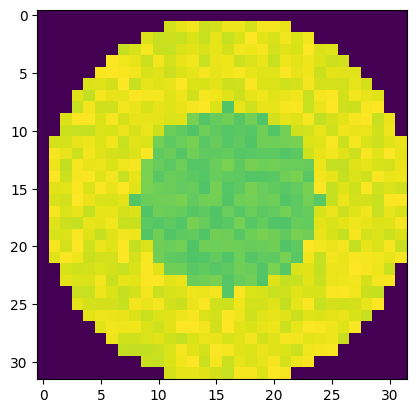

In [6]:
plt.imshow(messed_boundary_condition)

## Equation Instances and Static Model

In [7]:
from phylearn.nn.phyinformed.static import PhyStaticModel

In [8]:
D = 0.4
p = 0.7

limit = 100

# to use in training
diff_equation = FisherKolmogorovDiffEquation(boundary_condition, limit)

# to use in data generation
messed_diff_equation = FisherKolmogorovDiffEquation(messed_boundary_condition, limit)
messed_static_model = PhyStaticModel(messed_diff_equation, [D, p])

# Data

## Initial States

In [9]:
n_initial_states = 128
mattery_init= 0.99

initail_states = [
    (rand(state_shape) - mattery_init).clip(min=0) * limit
    for _ in range(n_initial_states)
]

## Data Generation

In [10]:
from phylearn.nn.training.data.record import RecordsGenerator

In [11]:
record_len = 16
time_step = 1

generate = RecordsGenerator(messed_static_model)
records = generate(initail_states, record_len, time_step)

## Visualization

In [12]:
from typing import Sequence
from random import randint

In [13]:
class SubplotManager:
    def __init__(self, num_columns):
        self.num_columns = num_columns
        self.rows = []

    def add_row(self, image_row: Sequence[Tensor]):
        if len(image_row) != self.num_columns:
            raise ValueError(f"Number of images in a row should be {self.num_columns}")

        self.rows.append(image_row)

    def show(self):
        num_rows = len(self.rows)
        fig, axes = plt.subplots(
            num_rows, self.num_columns, figsize=(4 * self.num_columns, 4 * num_rows)
        )

        for i, row in enumerate(self.rows):
            for j, image in enumerate(row):
                axes[i, j].imshow(image)
                axes[i, j].axis('off')

        plt.tight_layout()
        plt.show()

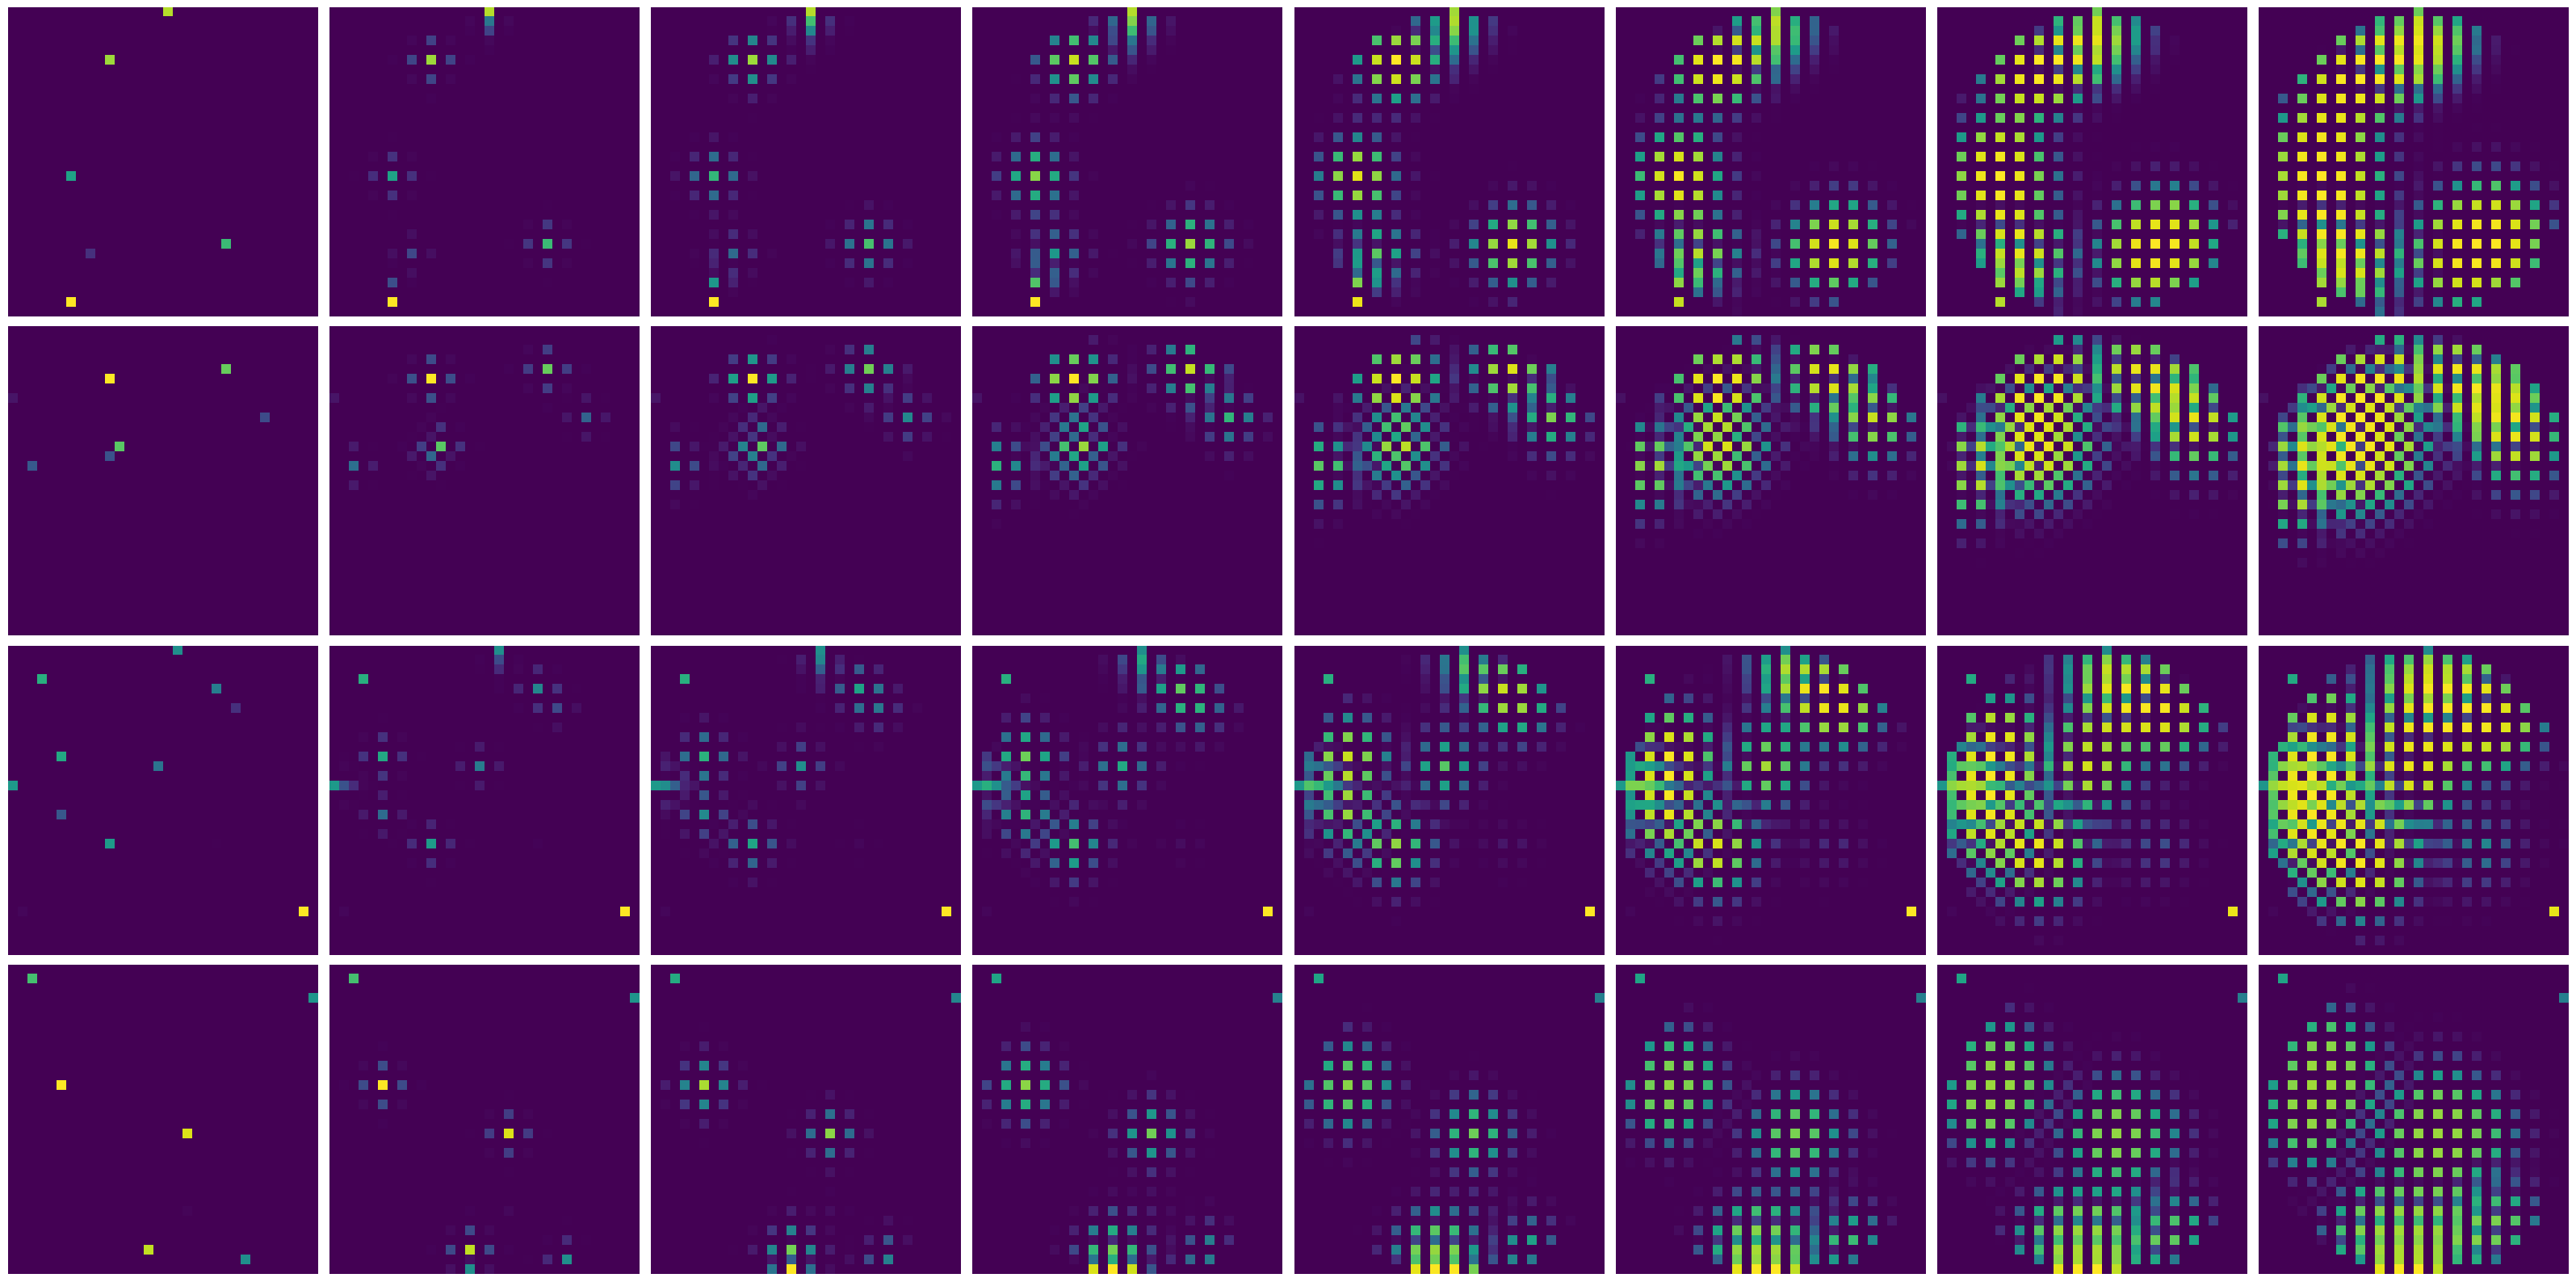

In [14]:
_records_to_show = 4
_images_per_record = 8

records_subplots = SubplotManager(_images_per_record)

for record in records[:_records_to_show]:
    images = []
    for i in range(0, record_len, record_len // _images_per_record):
        images.append(record.observations[i][0])
    records_subplots.add_row(images)

records_subplots.show()

## Train/Test split

In [15]:
train_test_split = int(0.75 * n_initial_states)
train_records = records[:train_test_split]
test_records = records[train_test_split:]

train_observations = cat([Tensor(r.observations) for r in train_records])
test_observations = cat([Tensor(r.observations) for r in test_records])

# Models

## Common Imports

In [16]:
from phylearn.nn.training.trainer import Trainer
from phylearn.nn.training.losses import ScaledLoss

from phylearn.nn.elementary import FCNet

## Autoencoder

In [17]:
from phylearn.nn.autoencoders.conv import ConvAutoencoder
from phylearn.nn.autoencoders.fc import FCAutoencoder

from torch.utils.data import TensorDataset

In [18]:
autoencoder_train_ds = TensorDataset(train_observations, train_observations)
autoencoder_test_ds = TensorDataset(test_observations, test_observations)

In [19]:
fc_autoencoder = FCAutoencoder([6272, 128])

autoencoder = ConvAutoencoder(
    state_shape, [1, 16, 8], [5, 5], sub_autoencoder=fc_autoencoder
)

In [20]:
autoencoder_loss_function = ScaledLoss(nn.HuberLoss())

autoencoder_trainer = Trainer() \
    .to_minimize(autoencoder_loss_function) \
    .optimize_with(optim.AdamW, lr=0.0001) \
    .with_training_on(autoencoder_train_ds, 64) \
    .with_validation_on(autoencoder_test_ds, 64)

autoencoder = autoencoder_trainer.fit(autoencoder, epochs=30)

Epoch 1
-------------------------------
    batch 1/24: train loss: 0.024787556380033493
    batch 2/24: train loss: 0.017753176391124725
    batch 3/24: train loss: 0.025573886930942535
    batch 4/24: train loss: 0.0254274383187294
    batch 5/24: train loss: 0.024514049291610718
    batch 6/24: train loss: 0.021642660722136497
    batch 7/24: train loss: 0.021256422623991966
    batch 8/24: train loss: 0.02409014292061329
    batch 9/24: train loss: 0.018982473760843277
    batch 10/24: train loss: 0.021381501108407974
    batch 11/24: train loss: 0.022001443430781364
    batch 12/24: train loss: 0.02139909192919731
    batch 13/24: train loss: 0.023716270923614502
    batch 14/24: train loss: 0.024128949269652367
    batch 15/24: train loss: 0.018401362001895905
    batch 16/24: train loss: 0.01858629658818245
    batch 17/24: train loss: 0.020511401817202568
    batch 18/24: train loss: 0.01754726655781269
    batch 19/24: train loss: 0.019741952419281006
    batch 20/24: train lo

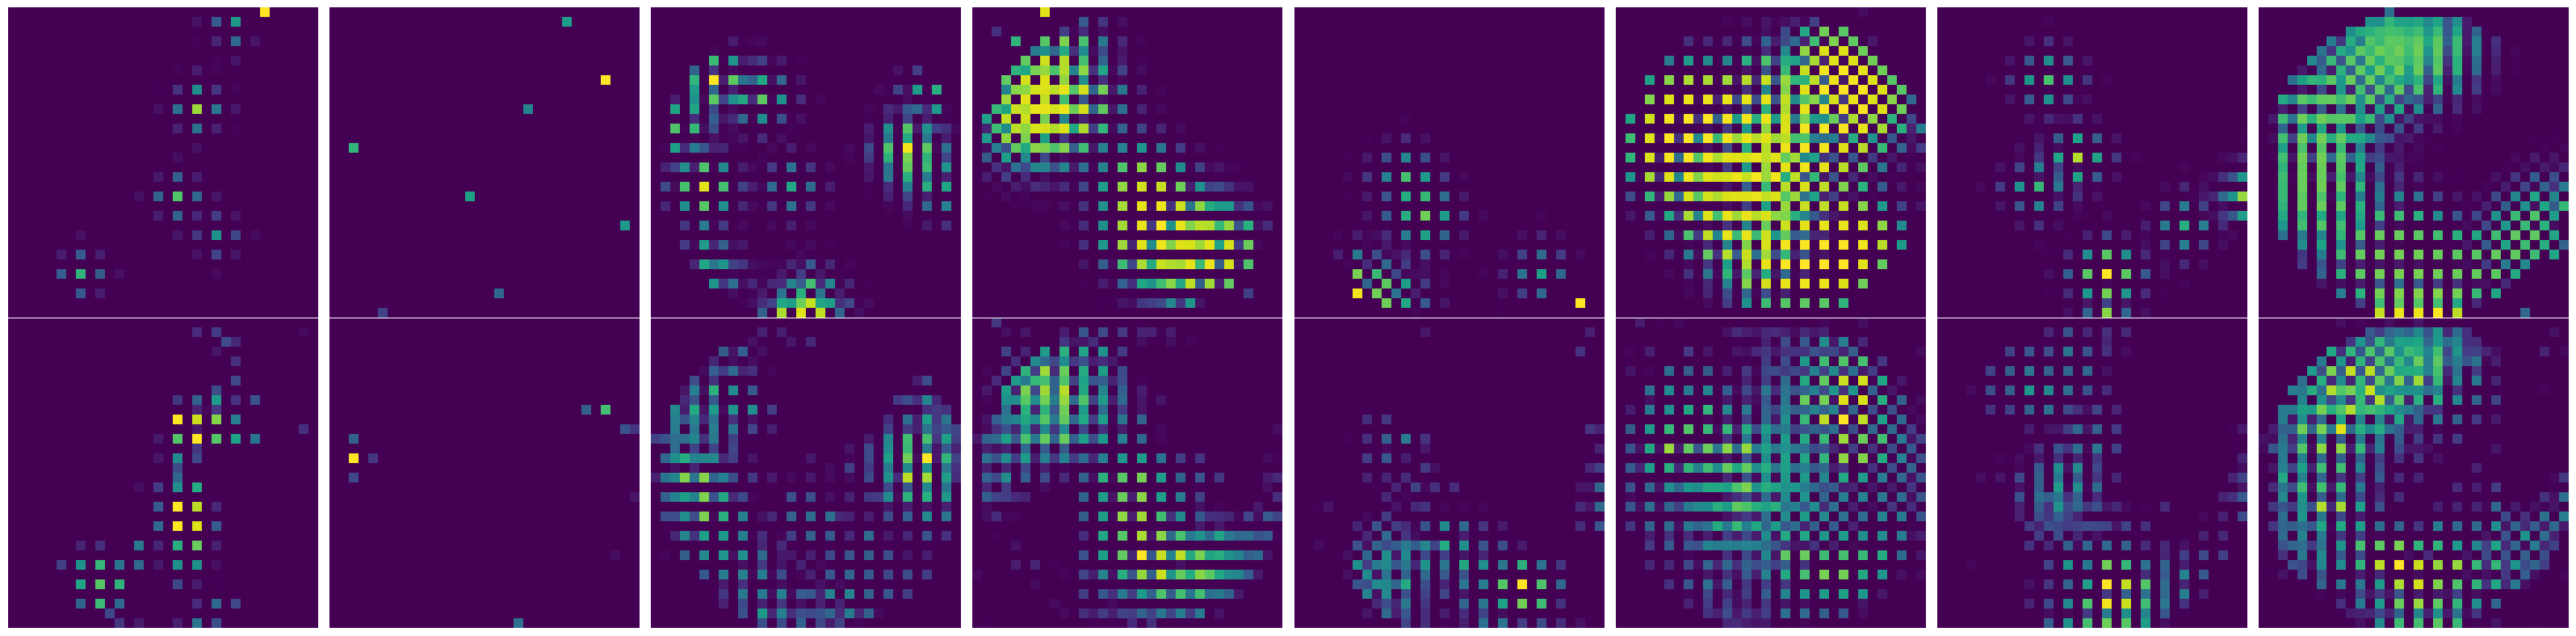

In [21]:
_n_autoencoder_exmaples = 8

_observations = [
    test_observations[randint(0, len(test_observations) - 1), 0] for _ in range(_n_autoencoder_exmaples)
]

with no_grad():
    _autoencoder_evals = [
        autoencoder(observation.unsqueeze(0).unsqueeze(0))[0, 0] for observation in _observations
    ]

autoencoder_subplots = SubplotManager(_n_autoencoder_exmaples)
autoencoder_subplots.add_row(_observations)
autoencoder_subplots.add_row(_autoencoder_evals)

autoencoder_subplots.show()

## Visualization

In [22]:
from phylearn.nn.phyinformed.abstract import SpatialTemporalNet
from phylearn.nn.training.data.sets import SpatialTemporalDataset

from random import choices

In [23]:
def visualize_phy_model_results(
    model: SpatialTemporalNet, dataset: SpatialTemporalDataset, n_examples: int
):
    inidices = choices(list(range(len(dataset))), k=n_examples)

    obsevations = []
    targets = []
    predicted = []
    diffs = []

    for i in inidices:
        (X, T), Y = dataset[i]

        with no_grad():
            Y_pred = model((X.unsqueeze(0), T))[0]
            
        diff = Y_pred - X

        obsevations.append(X[0])
        targets.append(Y[0])
        predicted.append(Y_pred[0])
        diffs.append(diff[0])

    subplots = SubplotManager(n_examples)

    subplots.add_row(obsevations)
    subplots.add_row(targets)
    subplots.add_row(predicted)
    subplots.add_row(diffs)

    subplots.show()

## Params Discovery Model

In [24]:
from phylearn.nn.training.data.sets import ManyOffsetsRecordDataset

from phylearn.nn.phyinformed.discovery import PhyDiscoveryModelNet
from phylearn.nn.phyinformed.utils import TimeContinuousNet

In [25]:
offsets = [3, 5, 7]

discovery_train_ds = ManyOffsetsRecordDataset(train_records, offsets)
discovery_test_ds = ManyOffsetsRecordDataset(test_records, offsets)

In [26]:
discovery_net = TimeContinuousNet(FCNet([129, 64, 32, 2]))
phy_discovery_net = PhyDiscoveryModelNet(discovery_net, diff_equation, autoencoder.encoder)

In [27]:
phy_discovery_loss_function = ScaledLoss(nn.HuberLoss())

phy_discovery_trainer = Trainer() \
    .to_minimize(phy_discovery_loss_function) \
    .optimize_with(optim.AdamW, lr=0.0001) \
    .with_training_on(discovery_train_ds, 64) \
    .with_validation_on(discovery_test_ds, 64)

phy_discovery_net = phy_discovery_trainer.fit(phy_discovery_net, epochs=10)

Epoch 1
-------------------------------
    batch 1/50: train loss: 0.015139350667595863
    batch 2/50: train loss: 0.013854119926691055
    batch 3/50: train loss: 0.01345633715391159
    batch 4/50: train loss: 0.014895707368850708
    batch 5/50: train loss: 0.015150247141718864
    batch 6/50: train loss: 0.014337277039885521
    batch 7/50: train loss: 0.01156649924814701
    batch 8/50: train loss: 0.014375797472894192
    batch 9/50: train loss: 0.015474049374461174
    batch 10/50: train loss: 0.013154378160834312
    batch 11/50: train loss: 0.01443957444280386
    batch 12/50: train loss: 0.01044248603284359
    batch 13/50: train loss: 0.011499357409775257
    batch 14/50: train loss: 0.010881556198000908
    batch 15/50: train loss: 0.012983222492039204
    batch 16/50: train loss: 0.00975048542022705
    batch 17/50: train loss: 0.015610925853252411
    batch 18/50: train loss: 0.015005161985754967
    batch 19/50: train loss: 0.013233710080385208
    batch 20/50: train l

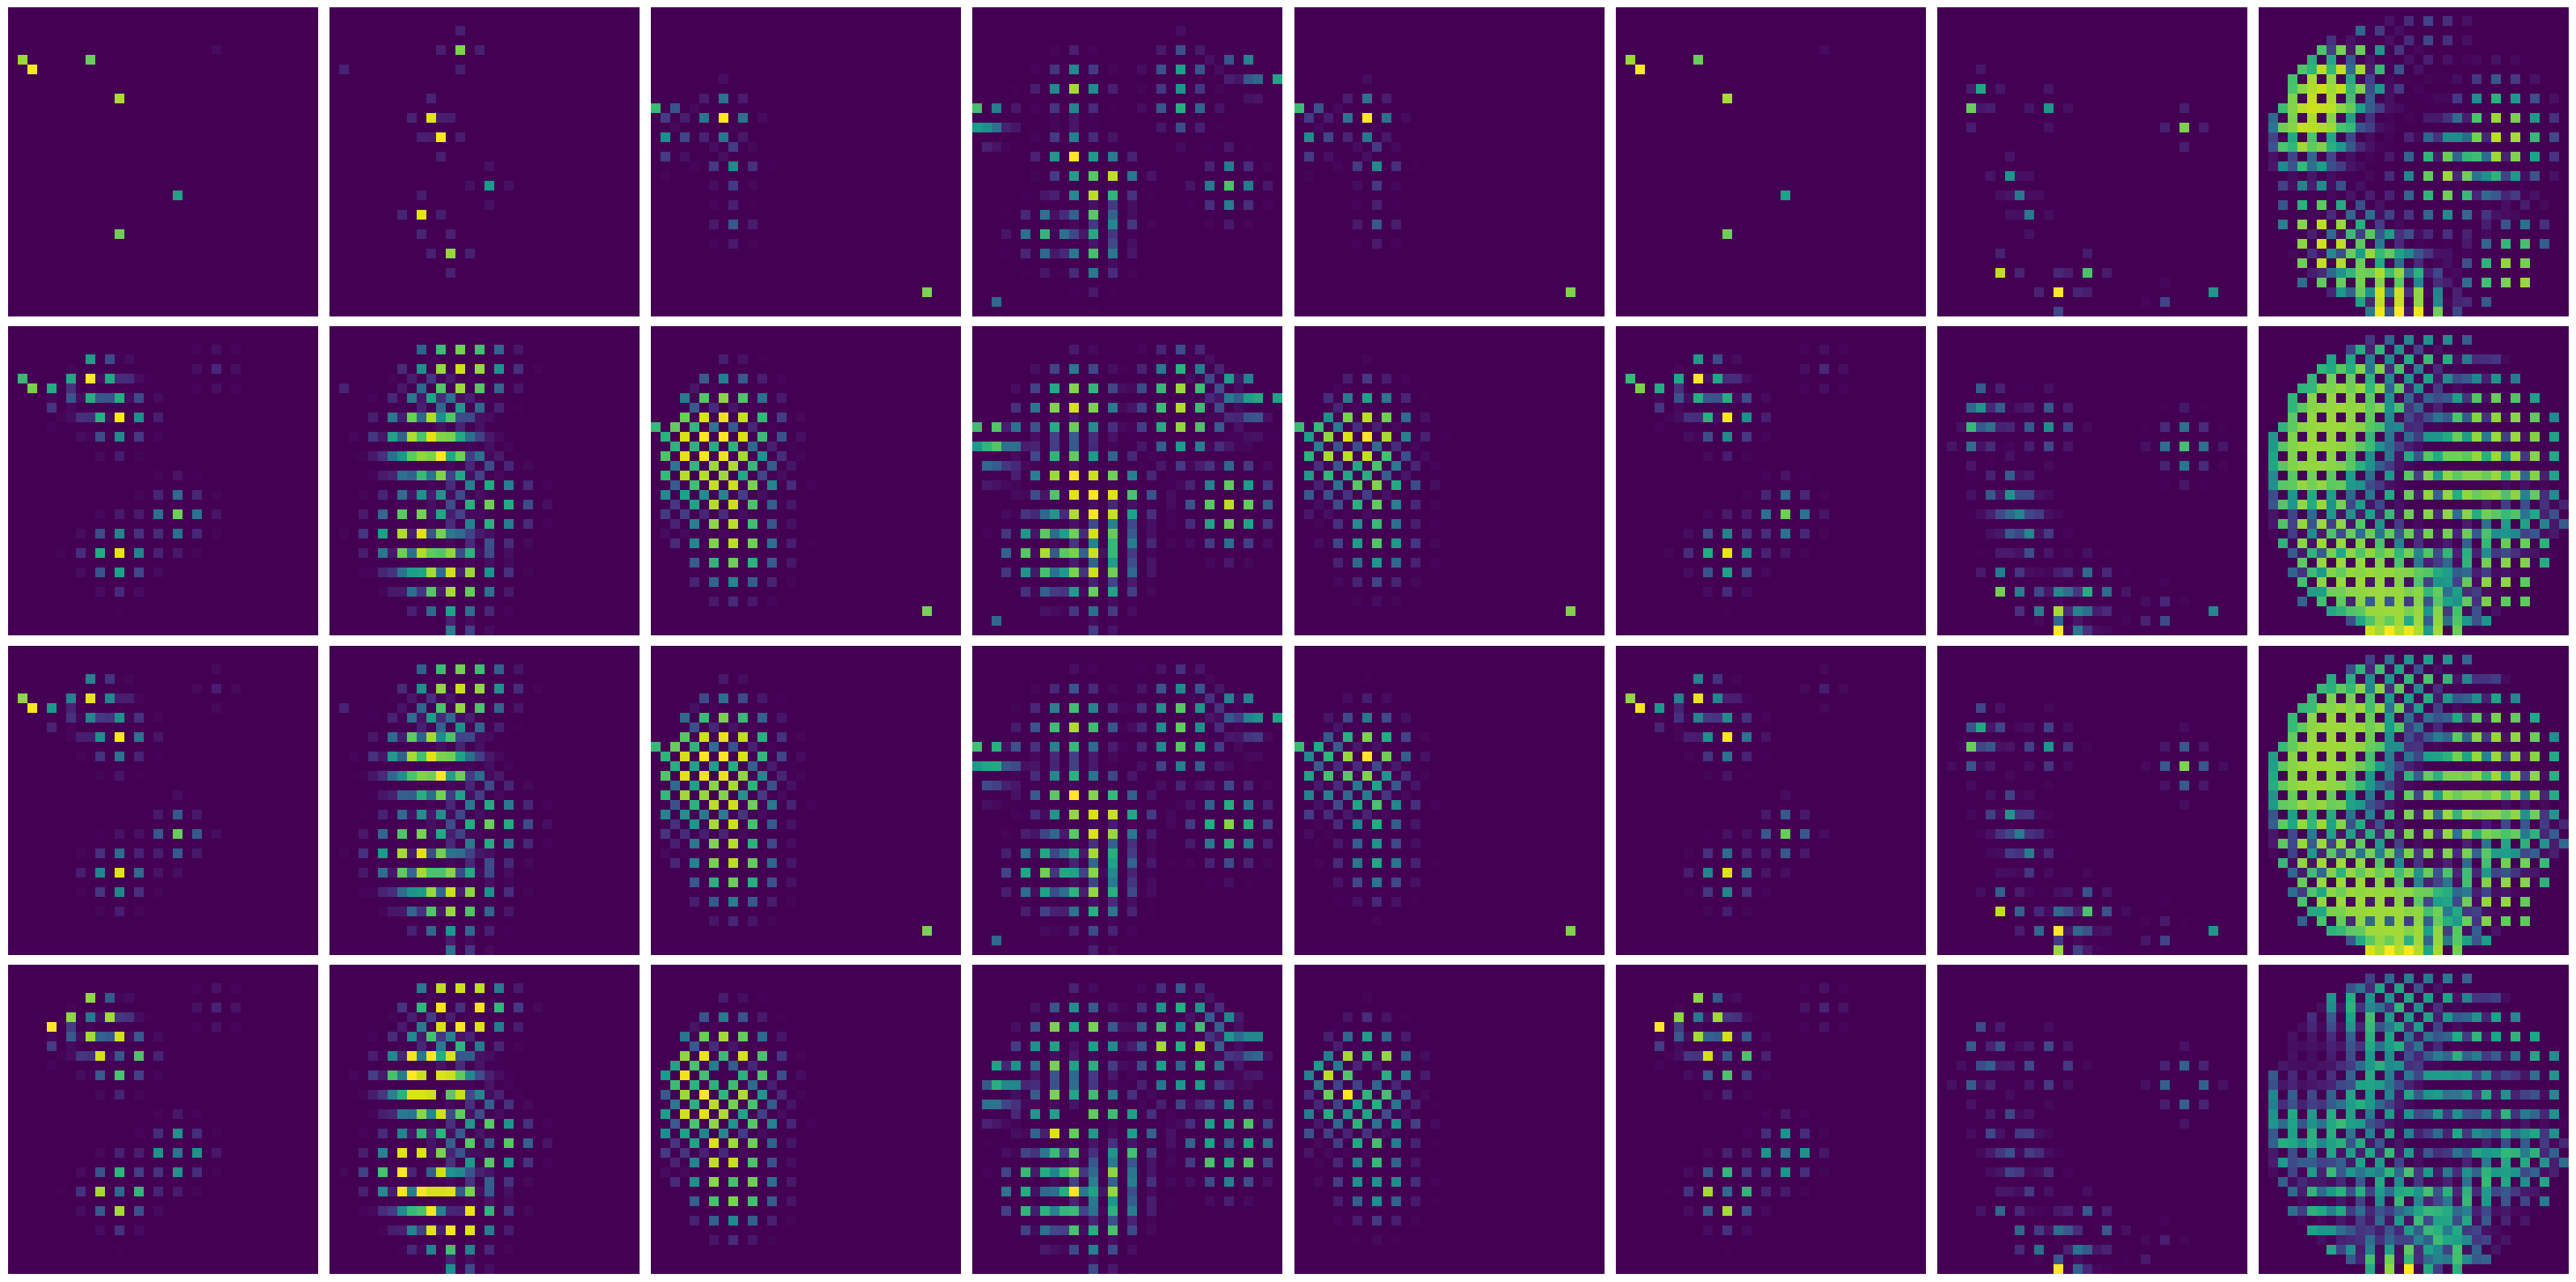

In [28]:
visualize_phy_model_results(phy_discovery_net, discovery_test_ds, 8)

In [29]:
with no_grad():
    for i in choices(list(range(len(discovery_test_ds))), k=8):
        (X, _), _ = discovery_test_ds[i]
        params = phy_discovery_net.pde_params(X.unsqueeze(0), Tensor([2]))
        print(params)

tensor([[0.2010, 0.2762]])
tensor([[0.2515, 0.5084]])
tensor([[0.2356, 0.3088]])
tensor([[0.2775, 0.3541]])
tensor([[0.2266, 0.2655]])
tensor([[0.3163, 0.5848]])
tensor([[0.2377, 0.2842]])
tensor([[0.2262, 0.2550]])


## Time Continuous Simulation Model

In [30]:
from phylearn.nn.training.data.sets import DatasetWithPhysics
from phylearn.nn.phyinformed.simulation import PhySimulationModelNet

In [31]:
simulation_train_ds = DatasetWithPhysics(discovery_train_ds, phy_discovery_net, 0.5) # type: ignore
simulation_test_ds = DatasetWithPhysics(discovery_test_ds, phy_discovery_net, 0.5)  # type: ignore

In [32]:
simulation_net = TimeContinuousNet(FCNet([129, 128, 128]))
phy_continuous_simulation_net = PhySimulationModelNet(simulation_net, autoencoder.encoder, autoencoder.decoder)

In [33]:
simulation_loss_function = ScaledLoss(nn.HuberLoss())

phy_simulation_trainer = Trainer() \
    .to_minimize(simulation_loss_function) \
    .optimize_with(optim.AdamW, lr=0.00025) \
    .with_training_on(simulation_train_ds, 64) \
    .with_validation_on(simulation_test_ds, 64)

In [34]:
phy_continuous_simulation_net = phy_simulation_trainer.fit(phy_continuous_simulation_net, epochs=10)

Epoch 1
-------------------------------
    batch 1/50: train loss: 0.021314769983291626
    batch 2/50: train loss: 0.023729704320430756
    batch 3/50: train loss: 0.026745958253741264
    batch 4/50: train loss: 0.024179261177778244
    batch 5/50: train loss: 0.02154231257736683
    batch 6/50: train loss: 0.020591571927070618
    batch 7/50: train loss: 0.02511177957057953
    batch 8/50: train loss: 0.021409042179584503
    batch 9/50: train loss: 0.0183583814650774
    batch 10/50: train loss: 0.02155645377933979
    batch 11/50: train loss: 0.020794454962015152
    batch 12/50: train loss: 0.019695531576871872
    batch 13/50: train loss: 0.024101117625832558
    batch 14/50: train loss: 0.018125824630260468
    batch 15/50: train loss: 0.020889826118946075
    batch 16/50: train loss: 0.018348217010498047
    batch 17/50: train loss: 0.019451096653938293
    batch 18/50: train loss: 0.016373835504055023
    batch 19/50: train loss: 0.017354710027575493
    batch 20/50: train l

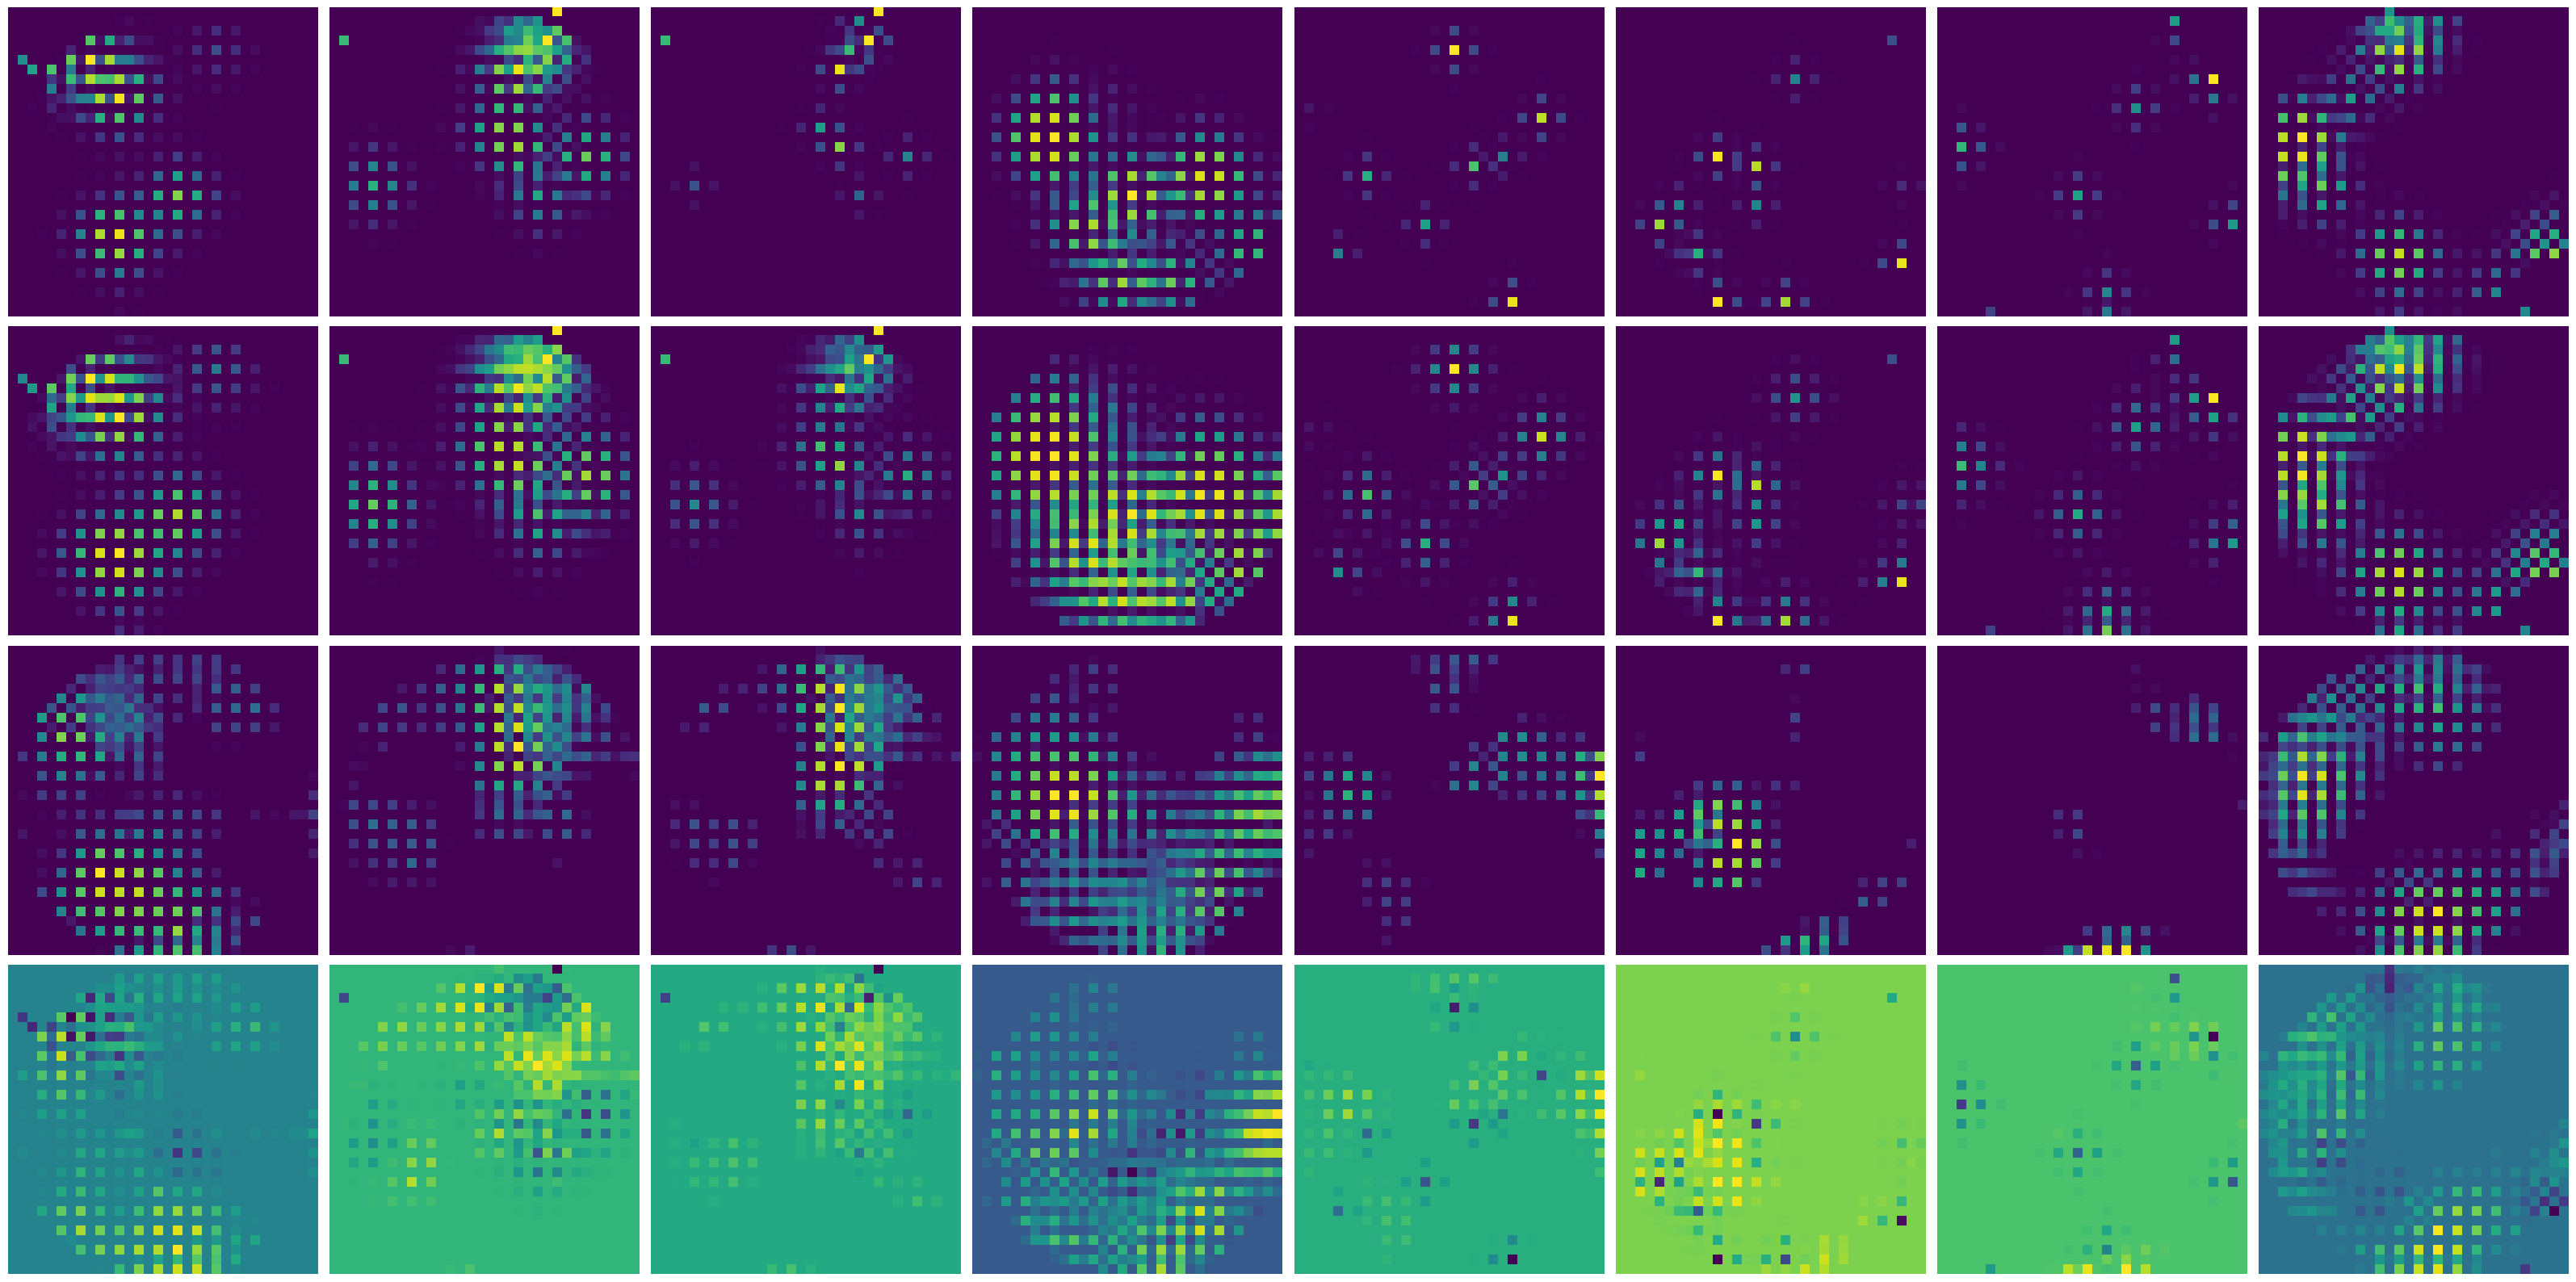

In [35]:
visualize_phy_model_results(phy_continuous_simulation_net, simulation_test_ds, 8)

## Time Discrete Simulation Model

In [36]:
from phylearn.nn.phyinformed.utils import TimeDiscreteNet

In [37]:
simulation_net = TimeDiscreteNet(FCNet([128, 128, 128]))
phy_discrete_simulation_net = PhySimulationModelNet(simulation_net, autoencoder.encoder, autoencoder.decoder)

In [38]:
phy_discrete_simulation_net = phy_simulation_trainer.fit(phy_discrete_simulation_net, epochs=20)

Epoch 1
-------------------------------
    batch 1/50: train loss: 0.6143134832382202
    batch 2/50: train loss: 0.2025851011276245
    batch 3/50: train loss: 0.04315617308020592
    batch 4/50: train loss: 0.0288371779024601
    batch 5/50: train loss: 0.022856738418340683
    batch 6/50: train loss: 0.019932584837079048
    batch 7/50: train loss: 0.030429527163505554
    batch 8/50: train loss: 0.0290133748203516
    batch 9/50: train loss: 0.025845181196928024
    batch 10/50: train loss: 0.026496408507227898
    batch 11/50: train loss: 0.026193782687187195
    batch 12/50: train loss: 0.022629909217357635
    batch 13/50: train loss: 0.027583841234445572
    batch 14/50: train loss: 0.02590441331267357
    batch 15/50: train loss: 0.023131268098950386
    batch 16/50: train loss: 0.02187502197921276
    batch 17/50: train loss: 0.029620174318552017
    batch 18/50: train loss: 0.02438359707593918
    batch 19/50: train loss: 0.02335340529680252
    batch 20/50: train loss: 0.0

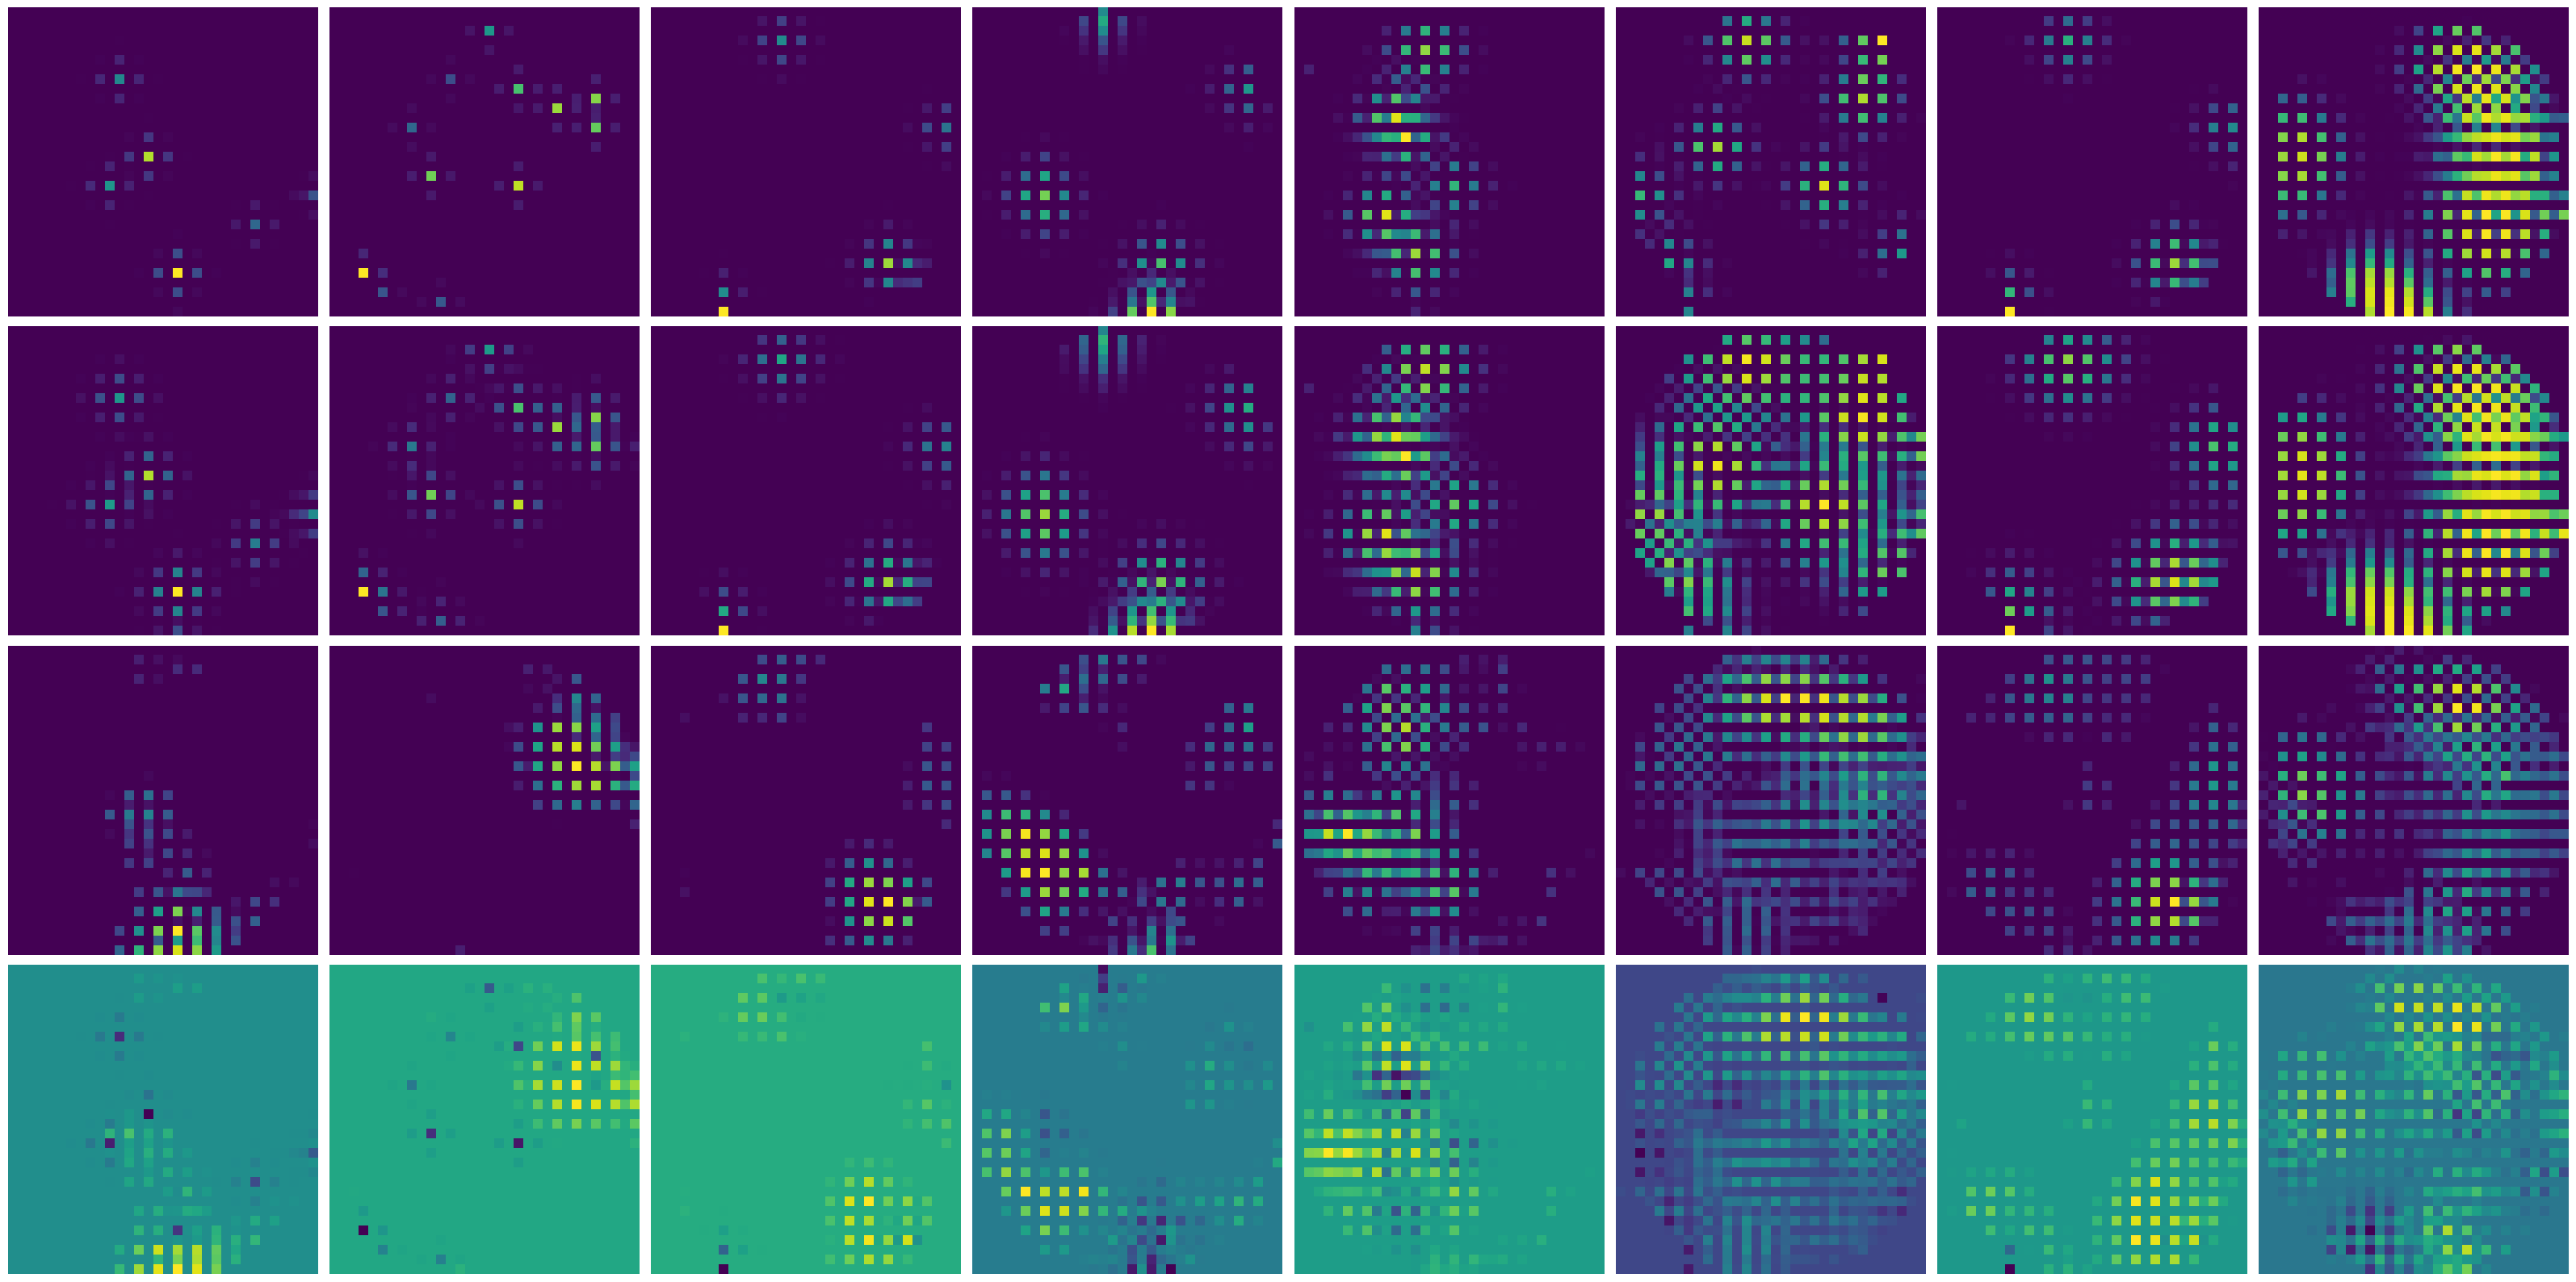

In [39]:
visualize_phy_model_results(phy_discrete_simulation_net, simulation_test_ds, 8)